notebook entrenamiento y validación con datos eliminados

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import logging

import random
from random import shuffle

import imgaug as ia
import imgaug.augmenters as iaa

logger = tf.get_logger()
logger.setLevel(logging.ERROR)


print("Num GPUS avadible:",len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUS avadible: 1


In [2]:
classes = ['0', '1', '2', '3', '4']

base_dir=os.path.join( 'prop')

train_dir = os.path.join( 'test_2cat' )
test_dir = os.path.join('val1_2cat')


In [3]:

val_dir = test_dir

train_0 = os.path.join(train_dir, '0') 
train_1 = os.path.join(train_dir, '1')
#train_2 = os.path.join(train_dir, '2') 
#train_3 = os.path.join(train_dir, '3')  
#train_4 = os.path.join(train_dir, '4') 

val_0 = os.path.join(val_dir, '0') 
val_1 = os.path.join(val_dir, '1')
#val_2 = os.path.join(val_dir, '2') 
#val_3 = os.path.join(val_dir, '3')  
#val_4 = os.path.join(val_dir, '4')  


#numeros
num_0_tr = len(os.listdir(train_0))
num_1_tr = len(os.listdir(train_1))
#num_2_tr = len(os.listdir(train_2))
#num_3_tr = len(os.listdir(train_3))
#num_4_tr = len(os.listdir(train_4))


num_0_v = len(os.listdir(val_0))
num_1_v = len(os.listdir(val_1))
#num_2_v = len(os.listdir(val_2))
#num_3_v = len(os.listdir(val_3))
#num_4_v = len(os.listdir(val_4))


total_train = num_0_tr + num_1_tr #+ num_2_tr + num_3_tr + num_4_tr
total_val = num_0_v + num_1_v #+ num_2_v + num_3_v + num_4_v
 

In [4]:
def rescale_0_to_1(image):
    """
    Rescale image to [0, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    return tf.image.convert_image_dtype(image, tf.float64)

def rescale_min_1_to_1(image):
    """
    Rescale image to [-1, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    # Image must be casted to float32 first.
    image = tf.cast(image, tf.float64)
    # Rescale image from [0, 255] to [0, 2].
    image = tf.multiply(image, 1. / 127.5)
    # Rescale to [-1, 1].
    return tf.subtract(image, 1.0)

In [5]:
def augment_pre(image):
    
    BRIGHTNESS_MIN_DELTA = 0.875
    BRIGHTNESS_MAX_DELTA = 1.125

    SATURATION_LOWER = 0.5
    SATURATION_UPPER = 1.5

    HUE_MIN_DELTA = 0.8
    HUE_MAX_DELTA = 1.2

    CONTRAST_LOWER = 0.5
    CONTRAST_UPPER = 1.5
    
    seq = iaa.Sequential([
        iaa.MultiplyBrightness((BRIGHTNESS_MIN_DELTA, BRIGHTNESS_MAX_DELTA)),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5), 
        iaa.LinearContrast((CONTRAST_LOWER,CONTRAST_UPPER)),
        iaa.MultiplyHue((HUE_MIN_DELTA, HUE_MAX_DELTA)),
        iaa.MultiplySaturation((SATURATION_LOWER, SATURATION_UPPER)),

    ], random_order=True) # apply augmenters in random order
    image=image.astype(np.uint8)
    image=seq(image=image)

    image= rescale_min_1_to_1(image)
    
    return image

In [6]:
img_height=299
img_width=299
batch_size=16


In [7]:
image_gen_train = ImageDataGenerator(
      preprocessing_function=augment_pre
)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(img_height,img_width),
                                                     class_mode='binary'
                                                     )

Found 42918 images belonging to 2 classes.


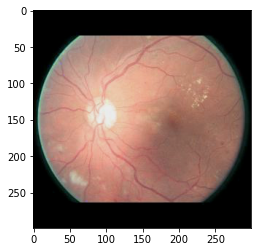

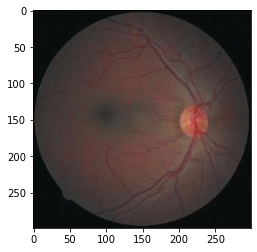

In [8]:

x,y= train_data_gen.next()

for i in range(0,2):
    image = x[i]
    plt.imshow((image+1)/2)
    plt.show()

In [9]:
image_gen_test = ImageDataGenerator(
    preprocessing_function=rescale_min_1_to_1
)

test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                   directory=val_dir,
                                                   target_size=(img_height,img_width),
                                                   class_mode='binary'
                                                  )

Found 16011 images belonging to 2 classes.


In [10]:
import math  
    
number_of_examples = len(test_data_gen.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * batch_size)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_data_gen[i][1]))

In [11]:

with tf.device('/GPU:0'):
    model = tf.keras.models.Sequential([
        tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', pooling='avg'),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    



    model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=1e-4,decay=4e-5),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy',tf.keras.metrics.AUC()])

    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [12]:

callbacks = [
    
    tf.keras.callbacks.EarlyStopping(
         monitor='val_auc', min_delta=0.001 , patience=10, verbose=0, mode='max',
        baseline=None, restore_best_weights=True
    ),
    
]

In [13]:
with tf.device('/GPU:0'):
    epochs=200
    history = model.fit(
        train_data_gen,
        steps_per_epoch=int(np.floor(total_train / float(batch_size))),
        epochs=epochs,
        validation_data=test_data_gen,
        validation_steps=int(np.ceil(total_val / float(batch_size))),
        callbacks=callbacks,
    )

Train for 2682 steps, validate for 1001 steps
Epoch 1/200
2682/2682 [==============================] - 2461s 918ms/step - loss: 0.6886 - accuracy: 0.7615 - auc: 0.5786 - val_loss: 0.6808 - val_accuracy: 0.7700 - val_auc: 0.6086
Epoch 2/200
2682/2682 [==============================] - 2543s 948ms/step - loss: 0.6829 - accuracy: 0.7772 - auc: 0.6217 - val_loss: 0.6803 - val_accuracy: 0.7703 - val_auc: 0.5995
Epoch 3/200
2682/2682 [==============================] - 3151s 1s/step - loss: 0.6791 - accuracy: 0.7862 - auc: 0.6397 - val_loss: 0.6793 - val_accuracy: 0.7868 - val_auc: 0.6681
Epoch 4/200
2682/2682 [==============================] - 1874s 699ms/step - loss: 0.6768 - accuracy: 0.7932 - auc: 0.6504 - val_loss: 0.6715 - val_accuracy: 0.7954 - val_auc: 0.6489
Epoch 5/200
2682/2682 [==============================] - 3448s 1s/step - loss: 0.6744 - accuracy: 0.7987 - auc: 0.6575 - val_loss: 0.6713 - val_accuracy: 0.7977 - val_auc: 0.6573
Epoch 6/200
2682/2682 [===========================

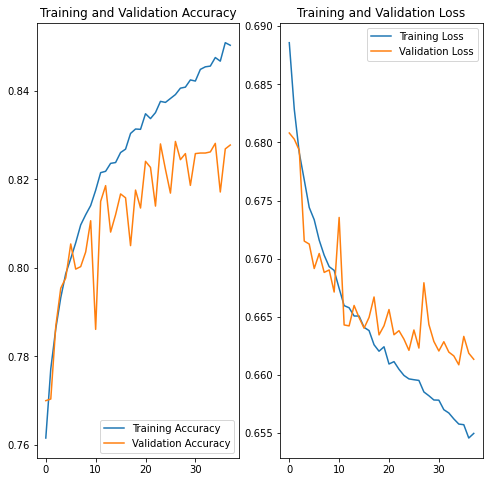

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
y_pred =  model.predict_generator(test_data_gen, steps= int(np.ceil(total_val / float(batch_size))))

In [16]:
print(y_pred.shape)

(16011, 1)


In [17]:
print(len(test_labels))

16011


In [18]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr , tpr , thresholds = roc_curve ( test_labels , y_pred)



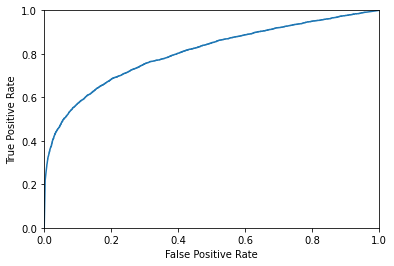

In [19]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr) 

Mantenemos resultados nefastos para el set de validación, aunque el nuevo optimizador con los nuevos parámetros proporciona un aprendizaje más rápido en el set de entrenamiento.

In [20]:
fpr[(np.where(tpr>=0.80))[0][0]]


0.39601769911504425

In [21]:

def tpr_to_umbrales(tpr,fpr,thresholds,lista):
    umbrales=[]
    fprumb=[]
    
    for i in lista:
        umbrales.append(thresholds[(np.where(tpr>=i))[0][0]])
        fprumb.append(fpr[(np.where(tpr>=i))[0][0]])
    
    return (umbrales, fprumb)  

In [22]:
lista=[0.98,0.95,0.90,0.80]
  

umbrales , fprumb =tpr_to_umbrales(tpr,fpr,thresholds,lista)

for idx,i in enumerate(lista):
    print("tpr:"+str(i)+"->fpr: "+str(fprumb[idx])+" con umbral: "+str(umbrales[idx]))

tpr:0.98->fpr: 0.9160993873383254 con umbral: 1.815159e-36
tpr:0.95->fpr: 0.7992682096664397 con umbral: 6.0347896e-33
tpr:0.9->fpr: 0.6349557522123894 con umbral: 1.182576e-28
tpr:0.8->fpr: 0.39601769911504425 con umbral: 1.1276648e-20


In [23]:
# Guardar el Modelo
model.save('prueban15.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
#new_model = tf.keras.models.load_model('miniprueba2.h5')